In [21]:
import pandas as pd
from ast import literal_eval
from transformers import AutoTokenizer

In [22]:
# 모델 변경
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")

In [23]:
prompt_no_question = (
    "지문:\n {paragraph}\n\n 질문:\n {question}\n\n 선택지:\n {choices}\n\n "
    "1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n 정답:"
)
prompt_with_question = (
    "지문:\n {paragraph}\n\n 질문:\n {question}\n\n <보기>:\n {question_plus}\n\n "
    "선택지:\n {choices}\n\n 1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n 정답:"
)

In [24]:
def parse_problems(df):
    records = []
    for _, row in df.iterrows():
        problems = literal_eval(row["problems"])
        record = {
            "id": row["id"],
            "paragraph": row["paragraph"],
            "question": problems["question"],
            "choices": problems["choices"],
            "answer": problems.get("answer", None),
            "question_plus": problems.get("question_plus", None),
        }
        records.append(record)
    return pd.DataFrame(records)

In [25]:
chat_template = """
{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}
{% if system_message is defined %}{{ system_message }}{% endif %}
{% for message in messages %}
    {% set content = message['content'] %}
    {% if message['role'] == 'user' %}{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}
    {% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>\n' }}
    {% endif %}
{% endfor %}
"""

In [26]:
# 파일 경로 수정
input_path = "../data/train.csv"
output_path = "../data/processed_train.csv"

In [27]:
def calculate_input_ids_length_with_chat_template(row):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(row["choices"])])

    if row["question_plus"]:
        user_message = prompt_with_question.format(
            paragraph=row["paragraph"],
            question=row["question"],
            question_plus=row["question_plus"],
            choices=choices_string,
        )
    else:
        user_message = prompt_no_question.format(
            paragraph=row["paragraph"],
            question=row["question"],
            choices=choices_string,
        )

    messages = [
        {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
        {"role": "user", "content": user_message},
        {"role": "assistant", "content": str(row["answer"])},
    ]

    formatted_text = tokenizer.apply_chat_template(
        messages,
        chat_template=chat_template,
        tools=None,  
        tokenize=False
    )

    tokens = tokenizer(formatted_text, truncation=False, padding=False, return_overflowing_tokens=False)
    return len(tokens["input_ids"])

input_df = pd.read_csv(input_path)

processed_df = parse_problems(input_df)
processed_df["input_ids_length"] = processed_df.apply(calculate_input_ids_length_with_chat_template, axis=1)-1

processed_df.to_csv(output_path, index=False, encoding='utf-8-sig')

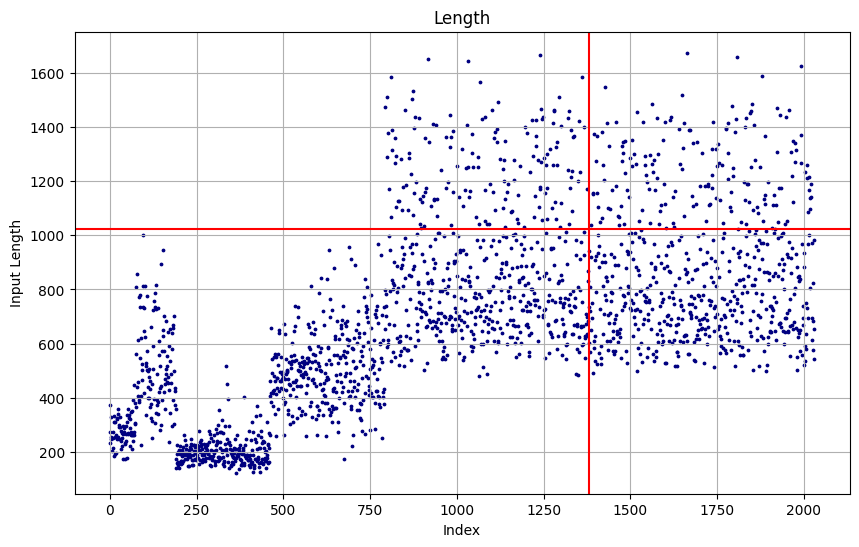

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(processed_df.index, processed_df['input_ids_length'],s=3,color='navy')
plt.axvline(x=1380, color='red', linestyle='-', linewidth=1.5)  # 빨간색 세로선
plt.axhline(y=1024, color='red', linestyle='-', linewidth=1.5)  # 가로선

plt.title('Length')
plt.xlabel('Index')
plt.ylabel('Input Length')
plt.grid()
plt.show()

In [29]:
processed_df[processed_df['input_ids_length']>2500]

,id,paragraph,question,choices,answer,question_plus,input_ids_length


In [30]:
for _,row in processed_df[processed_df["id"]=="generation-for-nlp-123"].iterrows():
    print(row["paragraph"])

In [31]:
processed_df.head()

,id,paragraph,question,choices,answer,question_plus,input_ids_length
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,374
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,234
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,274
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,329
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,254


In [32]:
processed_df["paragraph_length"]=processed_df["paragraph"].apply(len)
processed_df["question_length"]=processed_df["question"].apply(len)
processed_df["choices_length"]=processed_df["choices"].apply(" ".join).apply(len)
processed_df["all_length"]=processed_df["choices_length"] + processed_df["question_length"] + processed_df["paragraph_length"]

In [33]:
processed_df.head()

,id,paragraph,question,choices,answer,question_plus,input_ids_length,paragraph_length,question_length,choices_length,all_length
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,374,353,37,19,409
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,234,75,22,119,216
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,274,138,22,90,250
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,329,221,24,93,338
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,254,145,26,64,235


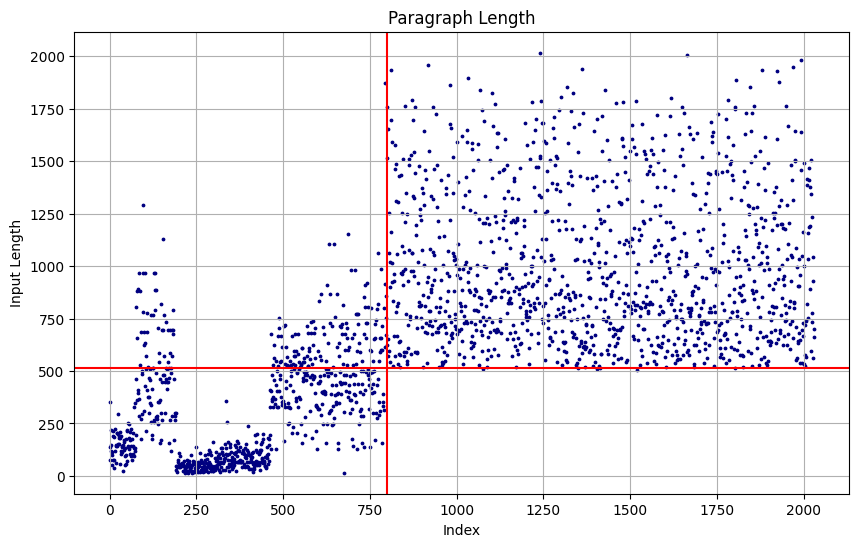

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(processed_df.index, processed_df['paragraph_length'],s=3,color='navy')
plt.axvline(x=800, color='red', linestyle='-', linewidth=1.5)  # 빨간색 세로선
plt.axhline(y=512, color='red', linestyle='-', linewidth=1.5)  # 가로선

plt.title('Paragraph Length')
plt.xlabel('Index')
plt.ylabel('Input Length')
plt.grid()
plt.show()

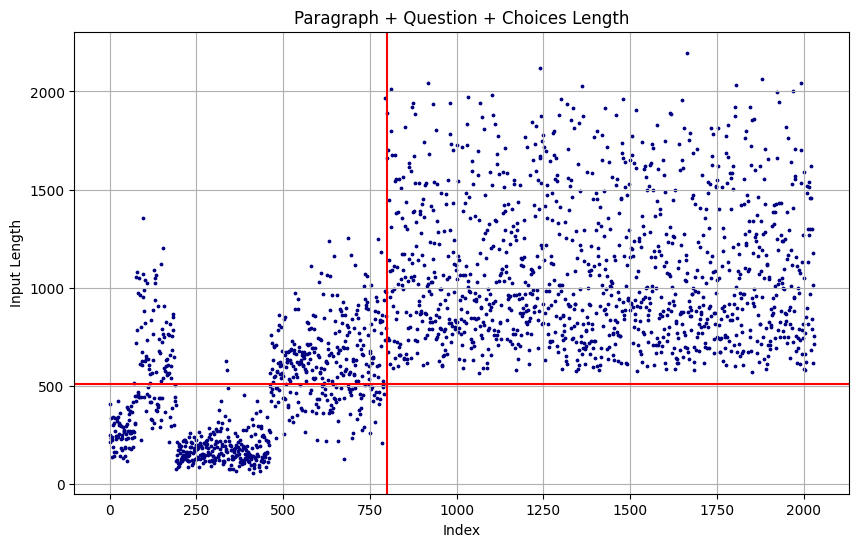

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(processed_df.index, processed_df['all_length'],s=3,color='navy')
plt.axvline(x=800, color='red', linestyle='-', linewidth=1.5)  # 빨간색 세로선
plt.axhline(y=512, color='red', linestyle='-', linewidth=1.5)  # 가로선

plt.title('Paragraph + Question + Choices Length')
plt.xlabel('Index')
plt.ylabel('Input Length')
plt.grid()
plt.show()